In [1]:
import torch
import rasterio
from torch.utils.data import Dataset
from torch.utils.data import ConcatDataset, random_split, DataLoader
from PIL import Image
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from collections import Counter
from tqdm.notebook import trange
import random
from torch.optim import SGD
import glob
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import Function_lib as lib

# Load one image/sample from the test set

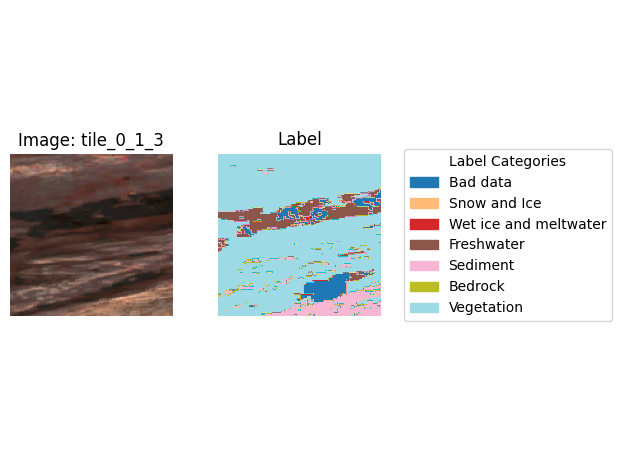

In [14]:
label_names = [
    "Bad data",
    "Snow and Ice",
    "Wet ice and meltwater",
    "Freshwater",
    "Sediment",
    "Bedrock",
    "Vegetation",
    ]

dataloader_test = DataLoader(lib.GreenlandData(split='test'), batch_size=1, num_workers=1)
image, label , imgName= iter(dataloader_test).__next__()

fig, axes = plt.subplots(1, 3)
axes[0].imshow(image[0])
axes[0].set_title(f'Image: {imgName[0]}')
axes[0].axis('off')

axes[1].imshow(label[0], cmap='tab20', vmin=0, vmax=len(label_names) - 1)
axes[1].set_title('Label')
axes[1].axis('off')

import matplotlib.patches as mpatches
colors = plt.cm.tab20(np.linspace(0, 1, len(label_names)))
patches = [mpatches.Patch(color=colors[i], label=label_names[i]) for i in range(len(label_names))]
    
axes[2].legend(handles=patches, loc='center', title="Label Categories")
axes[2].axis('off')

plt.tight_layout()
plt.show()


# Loads trained parameters from the best model you trained

In [ ]:
path_to_model = ''
model, epoch = lib.load_model("write model", path_to_model, epoch='latest')

# runs inference (i.e. applies the model) on one image from the test set

In [ ]:
device = 'cpu'
data = image
with torch.no_grad():
        pred = model(data.to(device))

        # get the label (i.e., the maximum position for each pixel along the class dimension)
        yhat = torch.argmax(pred, dim=1)
        


# displays the predicJons for this image

In [ ]:
fig, axes = plt.subplots(1, 3)
axes[0].imshow(label[0], cmap='tab20', vmin=0, vmax=len(label_names) - 1)
axes[0].set_title(f'Groundtruth')
axes[0].axis('off')

axes[1].imshow(yhat.squeeze(0).cpu().numpy(), cmap='tab20', vmin=0, vmax=len(label_names) - 1)
axes[1].set_title('Label')
axes[1].axis('off')

import matplotlib.patches as mpatches
colors = plt.cm.tab20(np.linspace(0, 1, len(label_names)))
patches = [mpatches.Patch(color=colors[i], label=label_names[i]) for i in range(len(label_names))]
axes[2].legend(handles=patches, loc='center', title="Label Categories")
axes[2].axis('off')

plt.tight_layout()
plt.show()